In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

from counterfactuals.cf_methods import PPCEF
from counterfactuals.datasets.file_dataset import FileDataset
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics.metrics import evaluate_cf
from counterfactuals.models import LogisticRegression, MaskedAutoregressiveFlow
from counterfactuals.plotting.counterfactual_visualization import plot_counterfactuals

/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = FileDataset(config_path="../config/datasets/moons.yaml")

X_train = dataset.X_train
X_test = dataset.X_test
y_train = dataset.y_train
y_test = dataset.y_test

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Train a discriminative model
num_inputs = X_train.shape[1]
num_targets = 1

discriminative_model = LogisticRegression(
    num_inputs=num_inputs,
    num_targets=num_targets,
)
discriminative_model.fit(
    train_dataloader, test_dataloader, epochs=10000, patience=600, lr=0.01
)

Epoch 683, Train: 0.2588, test: 0.2523, patience: 600:   7%|▋         | 683/10000 [00:04<00:57, 161.63it/s]


In [5]:
# Train a generative model
num_inputs = X_train.shape[1]
num_targets = 1

generative_model = MaskedAutoregressiveFlow(
    features=num_inputs,
    hidden_features=128,
    context_features=num_targets,
)
generative_model.fit(
    train_dataloader, test_dataloader, epochs=10000, patience=600, lr=0.01
)

Epoch 981, Train: 0.7391, test: 0.6581, patience: 600:  10%|▉         | 981/10000 [02:06<19:25,  7.74it/s]  


In [6]:
log_prob_threshold = np.median(generative_model.predict_log_prob(test_dataloader))

In [7]:
cf_method = PPCEF(
    disc_model=discriminative_model,
    gen_model=generative_model,
    disc_model_criterion=BinaryDiscLoss(),
)

X_test_orig = X_test[y_test == 0]
y_test_orig = y_test[y_test == 0]

cf_dataset = TensorDataset(
    torch.tensor(X_test_orig, dtype=torch.float32),
    torch.tensor(y_test_orig, dtype=torch.float32),
)

cf_dataloader = DataLoader(cf_dataset, batch_size=1024, shuffle=True)

results = cf_method.explain_dataloader(
    cf_dataloader,
    alpha=100,
    log_prob_threshold=log_prob_threshold,
    epochs=3000,
    patience=600,
    lr=0.01,
)

Discriminator loss: 0.0000, Prob loss: 0.0000: 100%|██████████| 3000/3000 [00:08<00:00, 365.04it/s]


/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


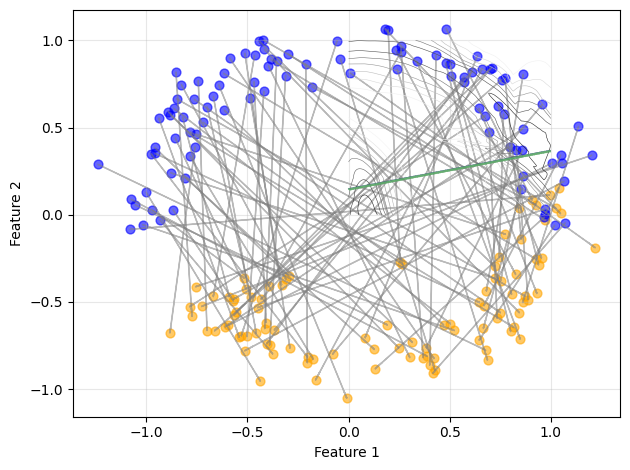

In [8]:
plot_counterfactuals(
    X_test_orig, results.x_cfs, 10, discriminative_model, gen_model=generative_model
)

In [9]:
evaluate_cf(
    disc_model=discriminative_model,
    gen_model=generative_model,
    X_cf=results.x_cfs,
    model_returned=np.ones_like(results.x_cfs),
    continuous_features=dataset.numerical_features,
    categorical_features=dataset.categorical_features,
    median_log_prob=log_prob_threshold,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lukasz/genwro/counterfactuals/methods_notebooks/counterfactuals/pipelines/conf/metrics/default.yaml'